In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, norm
from scipy.special import logsumexp
from numpy import array as npa
obs = np.load("observations.npy")

# ***Particle Gibbs with Ancestral Sampling***



### **SV Model**
$$
        x_1 \sim \mathcal{N}(0, \frac{\sigma^2}{1 - \alpha ^2}),
$$

$$
        x_n \sim \mathcal{N}(\alpha x_{n-1}, \sigma^2),
$$

$$
        y_n \sim \mathcal{N}(0,  \beta^2\exp(x_{n})),
$$

for $n=1,...,T$. We will assume that the parameters $\beta$ and $\sigma^2$ are unknown, while we assume that $\alpha=0.91$.

## **Conjugate priors**
We place inverse Gamma priors on the variance parameters:

\begin{align}
\sigma^2 & \sim \mathcal{IG}(a=0.01,b=0.01),
\\
\beta & \sim \mathcal{IG}(a=0.01,b=0.01),
\end{align}


where the the inverse Gamma pdf with parameters $(a,b)$ is given by
\begin{equation}
\mathcal{IG}(x|a,b)=\frac{b^a}{\Gamma(a)} x^{-a-1} \exp\left(-\frac{b}{x}\right)
\end{equation}
and $\Gamma$ is the Gamma function.

These priors are conjugate to the corresponding SV model pdf's and yield the following posteriors
\begin{equation}
    p(\sigma^2|x_{1:T}, \alpha) = \mathcal{IG}\left(\sigma^2|a + \frac{T}{2}, b + \frac{x_1^2(1 - \alpha^2)}{2} + \frac{1}{2}\sum^{T}_{n=2} (x_n - \alpha x_{n-1})^2\right),
\end{equation}

\begin{equation}
    p(\beta|x_{1:T}, y_{1:T}) = \mathcal{IG}\left(\beta|a + \frac{T}{2}, b + \frac{1}{2} \sum^T_{n=1}e^{-x_n}y_n^2\right)
\end{equation}

## **2.1 Implement the Particle Gibbs**
Implement a particle Gibbs sampler to compute the posterior distribution $p(\sigma^2,\beta|\alpha,y_{1:T})$. To do so, alternately sample from

*  $p(\sigma^2|\alpha,x_{1:T})$,
*  $p(\beta|x_{1:T},y_{1:T})$,
*  $p(x_{1:T}|\theta,y_{1:T})$ using conditional SMC.



In [202]:
#posteriors
def psigma2_sample(x, alpha=0.91, a=0.01, b=0.01):
    T = x.shape[1]
    alpha1 = a+T/2
    beta1 = b + (x[:,0]**2) * (1-alpha**2)/2 + np.sum((x[:,1:] - np.multiply(x[:,:T-1],alpha))**2, axis=1)/2
    return invgamma.rvs(alpha1, scale=beta1)

def pbeta_sample(x, y, a=0.01, b=0.01):
    T = x.shape[1]
    alpha1 = a+T/2
    beta1 = b + np.sum(np.divide((y**2), np.exp(x)), axis=1)/2
    return invgamma.rvs(alpha1, scale=beta1)

In [205]:
K = 100
T = obs.size
beta = 0.64
alpha = 0.91
sigma2 = 1

def pyx(yn, xkn, beta = beta): # alpha(x^k_n) 
    return norm.pdf(yn, 0, beta * np.sqrt(np.exp(xkn)))

def logpyx(yn, xkn, beta = beta): # alpha(x^k_n) 
    return norm.logpdf(yn, 0, beta * np.sqrt(np.exp(xkn)))

def sample_yn(xkn, beta = beta):
    return norm.rvs(0, beta * np.sqrt(np.exp(xkn)))

def sample_xn(xkn_1, alpha = alpha, sigma2 = sigma2):
    return norm.rvs(alpha * xkn_1, np.sqrt(sigma2))

def sample_x1(xkn_1, alpha = alpha, sigma2 = sigma2):
    return np.random.normal(0, np.sqrt(sigma2/(1-alpha**2)))

# resampling schemes in question 4
def multnorm_resamp(K, w):
    # return np.random.multinomial(K, w)
    mulinomial = np.random.multinomial(K, w)
    resamp = np.zeros(K, dtype=int)
    i = 0
    for j in range(0, K):
        k = i + mulinomial[j]
        while i < k:
            resamp[i] = j
            i += 1
    return resamp

In [206]:
class BFP:
    def __init__(self, sigma2, beta, xr = None, obs = obs, alpha = 0.91, scheme="multnorm", K=K) -> None:
        self.K = K # number of particles
        self.T = obs.size # number of iterations
        self.xkn = np.zeros((T, K)) # particles
        self.wn = np.zeros((T, K)) # weights (log)
        self.w_tilde = np.zeros((T, K)) # normalized weights (log)
        self.yn = npa(obs)
        self.samp = multnorm_resamp
        self.scheme = "multnorm"
        #initialization, first iteration
        self.xkn[0] = np.random.normal(0, np.sqrt(sigma2/(1-alpha**2)), size=K)
        self.xkn[0][self.K-1] = xr[0]
        self.wn[0] = npa([logpyx(self.yn[0], self.xkn[0][i], beta) for i in range(0,K)])
        self.w_tilde[0] = self.wn[0] - logsumexp(self.wn[0])
        self.ak = np.zeros((T, K), dtype=np.int32)
        self.ak[0] = np.arange(0,K)
        for n in range(1, self.T):
            # resampling  step
            self.ak[n] = self.samp(K, np.exp(self.w_tilde[n-1]))
            self.ak[n, self.K-1] = self.K-1
            self.xkn[n] = npa([sample_xn(self.xkn[n-1][self.ak[n, i]], alpha, sigma2) for i in range(0,K)])
            self.xkn[n][self.K-1] = xr[n]
            self.wn[n] = npa([logpyx(self.yn[n], self.xkn[n][i], beta) for i in range(0,K)])
            self.w_tilde[n] = self.wn[n] - logsumexp(self.wn[n])

    def sample_particle(self):
        k = np.random.choice(np.arange(0, self.K), p=np.exp(self.w_tilde[self.T-1]))
        turex = np.zeros(T) 
        for i in reversed(range(0, self.T)):
            turex[i] = self.xkn[i][k]
            k = self.ak[i][k]
        return turex
    
    def marginal(self):
        return np.exp(np.sum(logsumexp(self.wn, axis=1) - np.log(self.K)))

In [214]:
nchains = 3
burnin = 150
sigma2s = [np.abs(np.random.normal(0, 0.5, size=nchains))]
betas = [np.random.random(size=nchains)/2]
xr = [np.zeros((nchains, T))]
xr[0][:,0] = np.random.normal(0, np.sqrt(sigma2s[0]/(1-alpha**2)), size=nchains)
for n in range(1, T):
    xr[0][:,n] = sample_xn(xr[0][:,n-1], alpha, sigma2s[0])
marginal = 0
lastit = 0
for m in range(1,1000):
    new_sigma2 = psigma2_sample(xr[m-1])
    new_beta = pbeta_sample(xr[m-1], obs)
    bpf = [BFP(new_sigma2[c], new_beta[c], xr[m-1][c], obs) for c in range(0, nchains)]
    new_xrm = npa([bpf[c].sample_particle() for c in range(0,nchains)])
    sigma2s.append(new_sigma2)
    betas.append(new_beta)
    xr.append(new_xrm)
    if m > burnin:
        marginal += np.sum([bpf[c].marginal() for c in range(0,nchains)])
    if m > burnin and m%100 ==0:
        S = m-burnin+1
        s_inseqmean = np.mean(sigma2s[burnin:], axis=0)
        # s_overallmean = np.mean(s_inseqmean)
        
        s_betseqvar = S * np.var(s_inseqmean, ddof=1)
        s_withinseqvar = np.mean(np.var(sigma2s[burnin:], axis=0, ddof=1))
        s_averagevarV = ((S-1) * s_withinseqvar + s_betseqvar)/S
        s_R = np.sqrt(s_averagevarV / s_withinseqvar)

        b_inseqmean = np.mean(betas[burnin:], axis=0)
        b_betseqvar = S * np.var(b_inseqmean, ddof=1)
        b_withinseqvar = np.mean(np.var(betas[burnin:], axis=0, ddof=1))
        b_averagevarV = ((S-1) * b_withinseqvar + b_betseqvar)/S
        b_R = np.sqrt(b_averagevarV / b_withinseqvar)
        print("Iteration {0}: R_sigma2 = {1}, R_beta = {2}".format(m+1, s_R, b_R))
        if s_R <= 1.01 and b_R <= 1.01:
          lastit = bpf
          marginal = marginal / (3*(m-burnin+1))
          break
    if m == 999:
        lastit = bpf
        marginal = marginal / (3*(m-burnin+1))

Iteration 201: R_sigma2 = 1.1052451098711509, R_beta = 0.9981009372409105
Iteration 301: R_sigma2 = 1.0293725345574125, R_beta = 0.9972520387534363
Iteration 401: R_sigma2 = 1.0092824492294379, R_beta = 0.9983186932653652


## **Report the distributions $p(\sigma^2|\alpha,x_{1:T})$ and $p(\beta^2 |x_{1:T},y_{1:T})$, and the approximate marginal likelihood**

\begin{equation}
p(y_{1:T}|\theta) = \int_{x_{1:T}} p(y_{1:T}|x_{1:T}, \theta) p(x_{1:T}|\theta) dx_{1:T} \approx \prod_{i=1}^T \sum_k\frac{1}{K} p(y_i|x_i^k, \theta).
\end{equation}


In [217]:
def vis_betasigma():
    fig, axs = plt.subplots(2, 1, figsize=(13, 8))
    fig.suptitle('Beta-convergence')
    for i in range(0, nchains):
        axs[0].plot(betas[:25,i])
    axs[0].set(xlabel = 'Time(n)')
    axs[0].set(ylabel = 'beta')
    for i in range(0, nchains):
        axs[1].plot(np.arange(burnin, len(betas)), betas[burnin:,i])
    axs[1].set(xlabel = 'Time(n)')
    axs[1].set(ylabel = 'beta')
    fig.tight_layout(pad=1)
    plt.show()

    fig, axs = plt.subplots(1, 1)
    fig.suptitle('Beta-distribution')
    for i in range(0, nchains):
        axs.hist(betas[burnin:,i],alpha=0.5)
    plt.show()

    fig, axs = plt.subplots(2, 1, figsize=(13, 8))
    fig.suptitle('Sigma^2-convergence')
    for i in range(0, nchains):
        axs[0].plot(sigma2s[:61,i])
    axs[0].set(xlabel = 'Time(n)')
    axs[0].set(ylabel = 'sigma^2')
    for i in range(0, nchains):
        axs[1].plot(np.arange(burnin, len(sigma2s)), sigma2s[burnin:,i])
    axs[1].set(xlabel = 'Time(n)')
    axs[1].set(ylabel = 'sigma^2')
    fig.tight_layout(pad=1)
    plt.show()

    fig, axs = plt.subplots(1, 1)
    fig.suptitle('Sigma^2-distribution')
    for i in range(0, nchains):
        axs.hist(sigma2s[burnin:,i],alpha=0.5)
    plt.show()

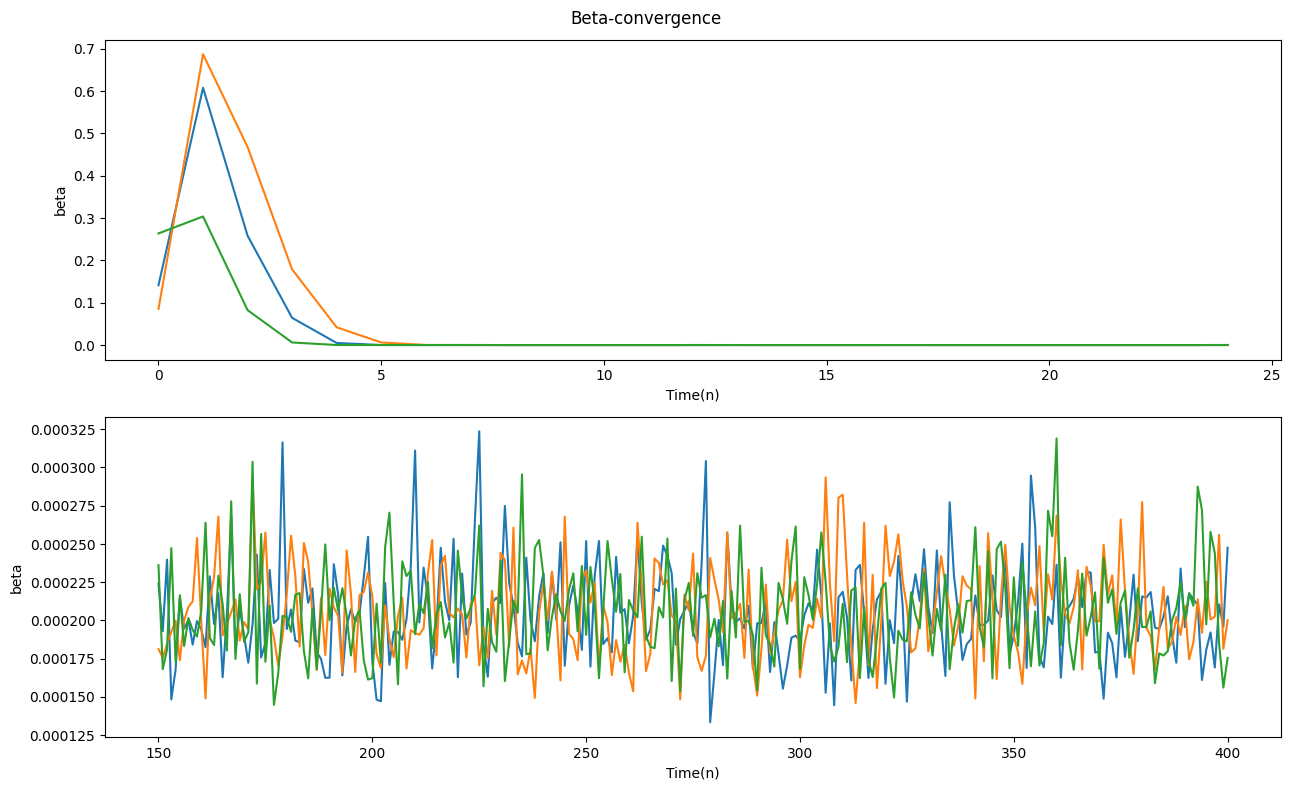

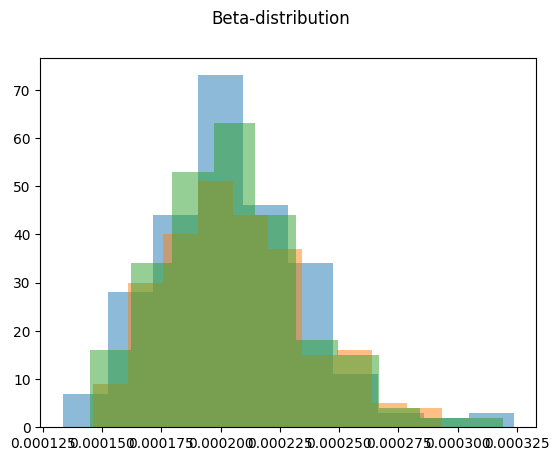

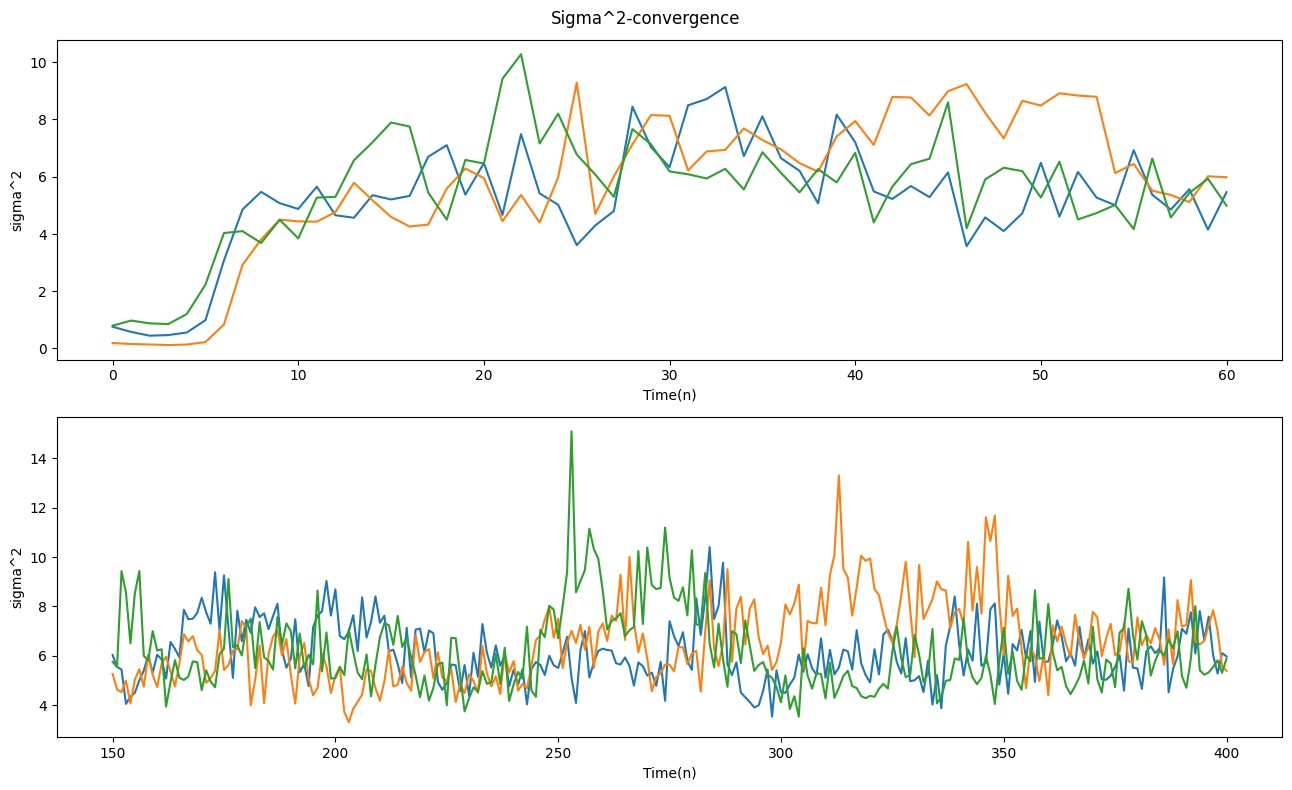

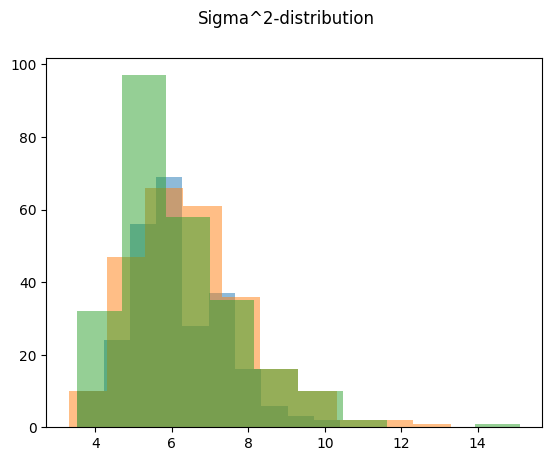

In [218]:
betas = npa(betas)
sigma2s = npa(sigma2s)
vis_betasigma()

In [220]:
print("Marginal likelihood: {}".format(marginal))

Marginal likelihood: 1.97914531435544e-61


## **Visualize the path degeneracy**
The method below comes from the template.

In [87]:
def particleGeneologyAll(title, particles, B, x_true=None, x_rs=None): 
    # particle: the inferred latent states at each time step shape=(num_particles, total_time)
    # B: the complete ancestry shape=(num_particles, total_time)  
    plt.figure(figsize=(14, 8)) 
    N, T = particles.shape 
    x_matrix = np.arange(T)

    # plot all the particles first
    for j in range(N): 
        plt.scatter(x_matrix, particles[j], color="lightgrey", s=5) 
     
    # plot geneology of survived 
    x_star = np.zeros(T) 
    for j in range(N): 
        curr = j 
        i = T-1 
        x_star[i] = particles[j, T-1] 
        for t in reversed(range(T-1)): 
            if curr == N - 1 and j != N - 1: 
                # Originated from reference particle 
                break 
            indx = B[curr, t+1] 
            x_star[i-1] = particles[indx, t] 
            curr = indx 
            i -= 1 
        x_dim = range(t, T) 
         
        if j == N - 1 and x_rs is None: 
            plt.plot(x_dim, x_star, color='blue', linewidth=3) 
        else: 
            plt.plot(x_dim, x_star[t:], color='black', marker='.', markersize=5, lw=1,
                    alpha=0.8, antialiased=True)
     
    if x_rs is not None: 
        for t, resampled, original in zip(range(T), x_rs[0], x_rs[1]): 
            plt.plot((t-1, t), (resampled, original), color='blue', linewidth=3)
     
    if x_true is not None:  
        plt.plot(x_true, color='g', linewidth=3) 
     
    plt.title(title) 
    plt.ylabel('Volatility') 
    plt.xlabel('t') 
    plt.show() 

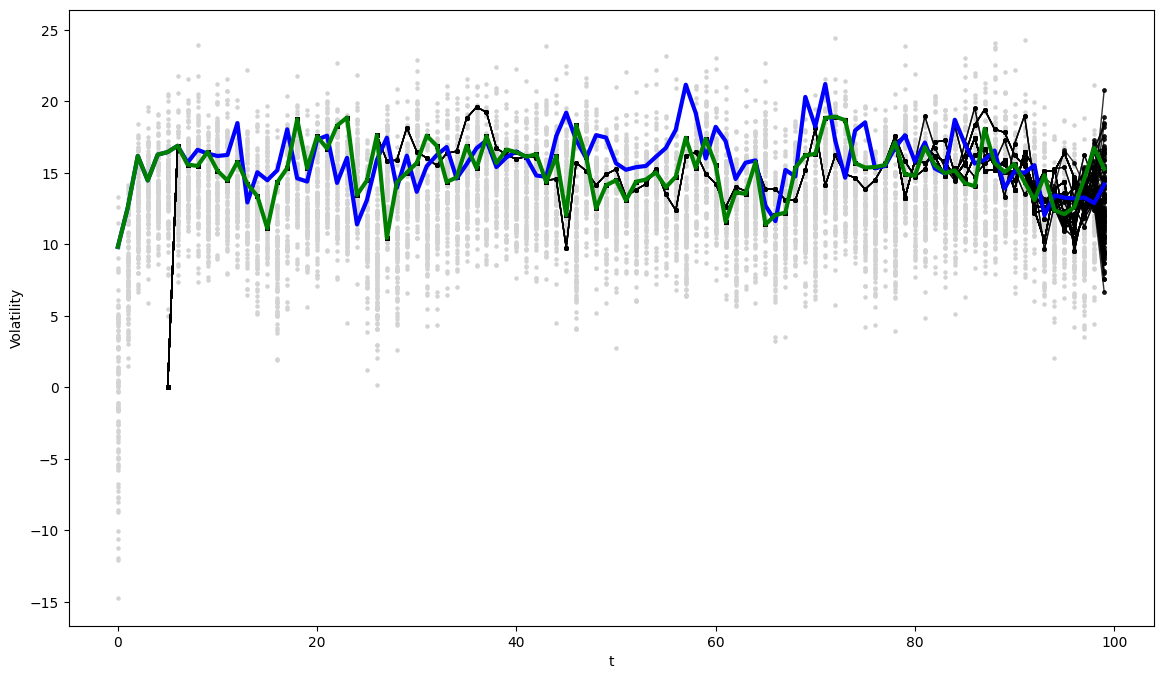

In [221]:
i=0
particleGeneologyAll("", np.transpose(lastit[i].xkn), np.transpose(lastit[i].ak), x_true=xr[len(xr)-1][i])

## **2.2 Implement the Particle Gibbs with Ancestral Sampling (PGAS)**
"[Particle Gibbs with ancestor sampling](https://www.jmlr.org/papers/volume15/lindsten14a/lindsten14a.pdf)" 



In [222]:
# resample particle N. 
# Parameters: xrn:=x^r_n, xkn_1:= x^k_{n-1}, wn_1:=log(w^k_{n-1})
def resamp_xr(xrn, xkn_1, wn_1, alpha = alpha, sigma2 = sigma2):
    # log of  p(x^r_n | x^k_{n-1}).
    logpxx = norm.logpdf(xrn, alpha * xkn_1, np.sqrt(sigma2))
    # P(a^N_t = j) 
    Pant = wn_1 + logpxx
    Pant = np.exp(Pant - logsumexp(Pant))
    ant = np.random.choice(np.arange(0, xkn_1.size), p=Pant)
    return ant

In [223]:
class BFPAS:
    def __init__(self, sigma2, beta, xr = None, obs = obs, alpha = 0.91, scheme="multnorm", K=K) -> None:
        self.K = K # number of particles
        self.T = obs.size # number of iterations
        self.xkn = np.zeros((T, K)) # particles
        self.wn = np.zeros((T, K)) # weights (log)
        self.w_tilde = np.zeros((T, K)) # normalized weights (log)
        self.yn = npa(obs)
        self.samp = multnorm_resamp
        self.scheme = "multnorm"
        #initialization, first iteration
        self.xkn[0] = np.random.normal(0, np.sqrt(sigma2/(1-alpha**2)), size=K)
        self.xkn[0][self.K-1] = xr[0]
        self.wn[0] = npa([logpyx(self.yn[0], self.xkn[0][i], beta) for i in range(0,K)])
        self.w_tilde[0] = self.wn[0] - logsumexp(self.wn[0])
        self.ak = np.zeros((T, K), dtype=np.int32)

        for n in range(1, self.T):
            # resampling  step
            self.ak[n] = self.samp(K, np.exp(self.w_tilde[n-1]))
            self.xkn[n,:K-1] = npa([sample_xn(self.xkn[n-1][self.ak[n, i]], alpha, sigma2) for i in range(0,K-1)])
            self.xkn[n][self.K-1] = xr[n]
            self.ak[n,K-1] = resamp_xr(xr[n], self.xkn[n-1], np.zeros(K), alpha, sigma2)
            
            self.wn[n] = npa([logpyx(self.yn[n], self.xkn[n][i], beta) for i in range(0,K)])
            self.w_tilde[n] = self.wn[n] - logsumexp(self.wn[n])
    
    def sample_particle(self):
        k = np.random.choice(np.arange(0, self.K), p=np.exp(self.w_tilde[self.T-1]))
        turex = np.zeros(T) 
        for i in reversed(range(0, self.T)):
            turex[i] = self.xkn[i][k]
            k = self.ak[i][k]
        return turex
    
    def marginal(self):
        return np.exp(np.sum(logsumexp(self.wn, axis=1) - np.log(self.K)))

In [224]:
nchains = 3
burnin = 150
sigma2s = [np.abs(np.random.normal(0, 0.5, size=nchains))]
betas = [np.random.random(size=nchains)/2]
xr = [np.zeros((nchains, T))]
xr[0][:,0] = np.random.normal(0, np.sqrt(sigma2s[0]/(1-alpha**2)), size=nchains)
for n in range(1, T):
    xr[0][:,n] = sample_xn(xr[0][:,n-1], alpha, sigma2s[0])
marginal = 0
lastit = 0
for m in range(1,1000):
    new_sigma2 = psigma2_sample(xr[m-1])
    new_beta = pbeta_sample(xr[m-1], obs)
    bpf = [BFPAS(new_sigma2[c], new_beta[c], xr[m-1][c], obs) for c in range(0, nchains)]
    new_xrm = npa([bpf[c].sample_particle() for c in range(0,nchains)])
    sigma2s.append(new_sigma2)
    betas.append(new_beta)
    xr.append(new_xrm)
    if m > burnin:
        marginal += np.sum([bpf[c].marginal() for c in range(0,nchains)])
    if m > burnin and m%100 ==0:
        S = m-burnin+1
        s_inseqmean = np.mean(sigma2s[burnin:], axis=0)
        # s_overallmean = np.mean(s_inseqmean)
        
        s_betseqvar = S * np.var(s_inseqmean, ddof=1)
        s_withinseqvar = np.mean(np.var(sigma2s[burnin:], axis=0, ddof=1))
        s_averagevarV = ((S-1) * s_withinseqvar + s_betseqvar)/S
        s_R = np.sqrt(s_averagevarV / s_withinseqvar)

        b_inseqmean = np.mean(betas[burnin:], axis=0)
        b_betseqvar = S * np.var(b_inseqmean, ddof=1)
        b_withinseqvar = np.mean(np.var(betas[burnin:], axis=0, ddof=1))
        b_averagevarV = ((S-1) * b_withinseqvar + b_betseqvar)/S
        b_R = np.sqrt(b_averagevarV / b_withinseqvar)
        print("Iteration {0}: R_sigma2 = {1}, R_beta = {2}".format(m+1, s_R, b_R))
        if s_R <= 1.01 and b_R <= 1.01:
          lastit = bpf
          marginal = marginal / (3*(m-burnin+1))
          break
    if m == 999:
        lastit = bpf
        marginal = marginal / (3*(m-burnin+1))

Iteration 201: R_sigma2 = 1.0518486953608595, R_beta = 0.997350954756871
Iteration 301: R_sigma2 = 1.0014665055152043, R_beta = 1.0031963412169134


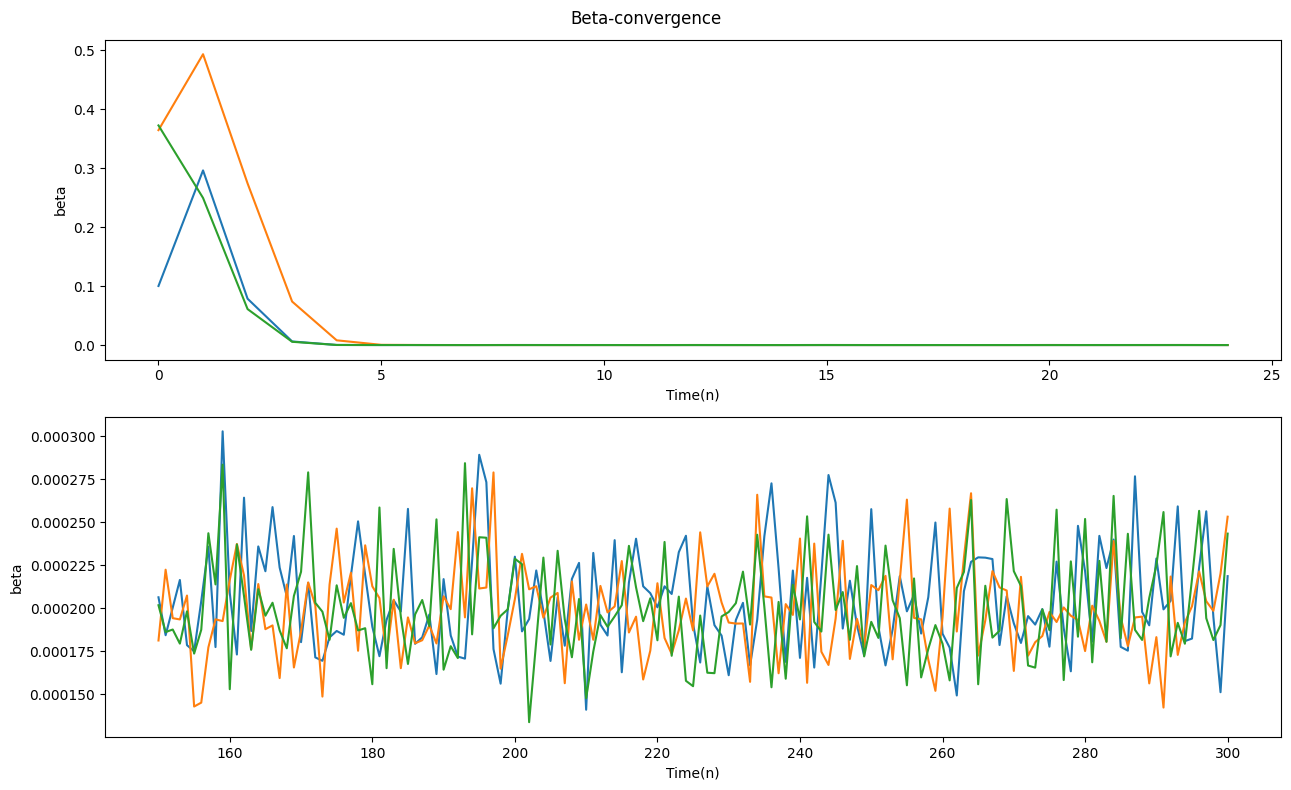

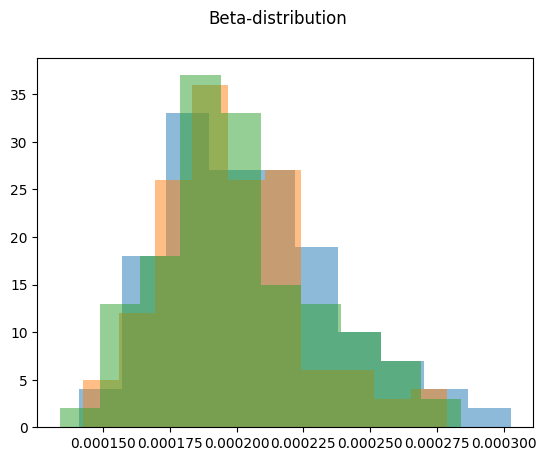

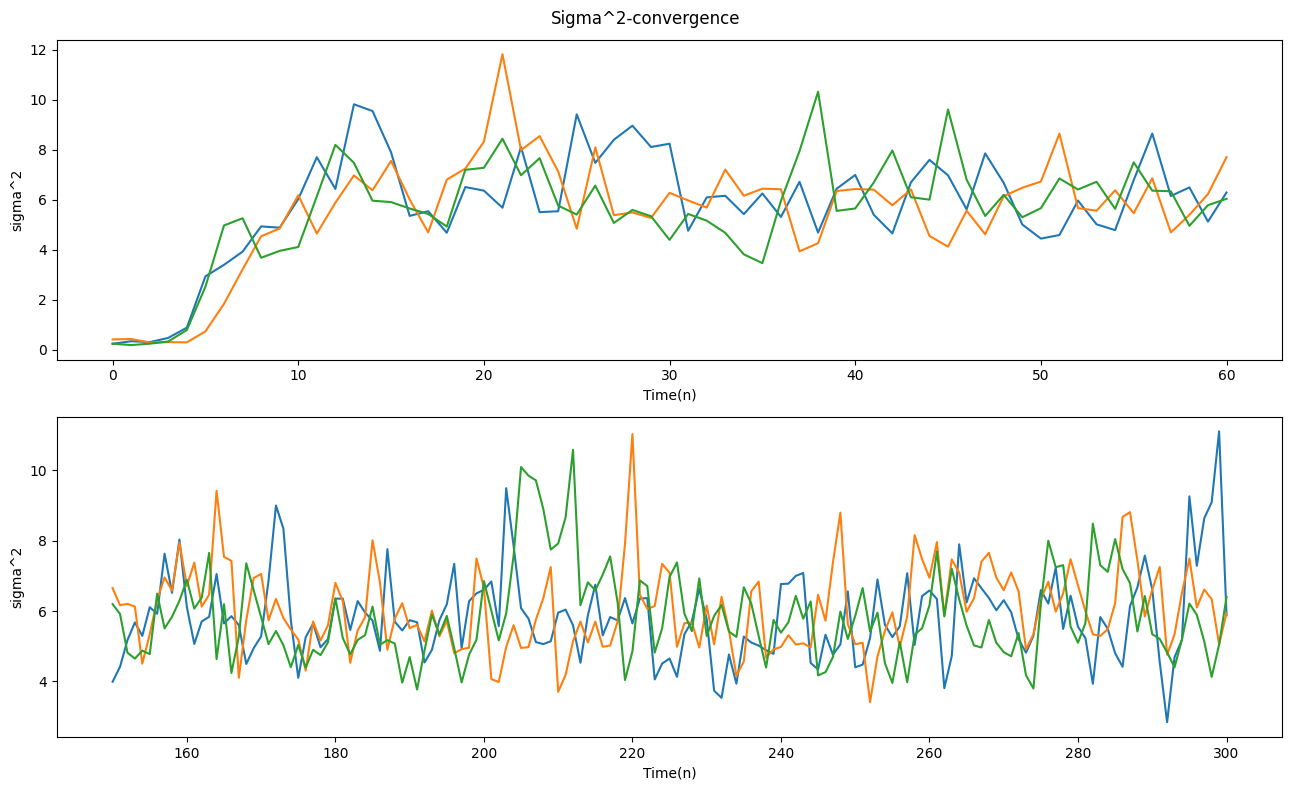

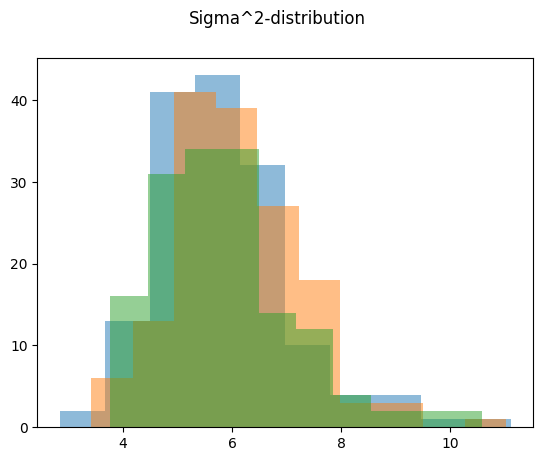

In [225]:
betas = npa(betas)
sigma2s = npa(sigma2s)
vis_betasigma()

In [226]:
print("Marginal likelihood: {}".format(marginal))

Marginal likelihood: 2.379999798435791e-61


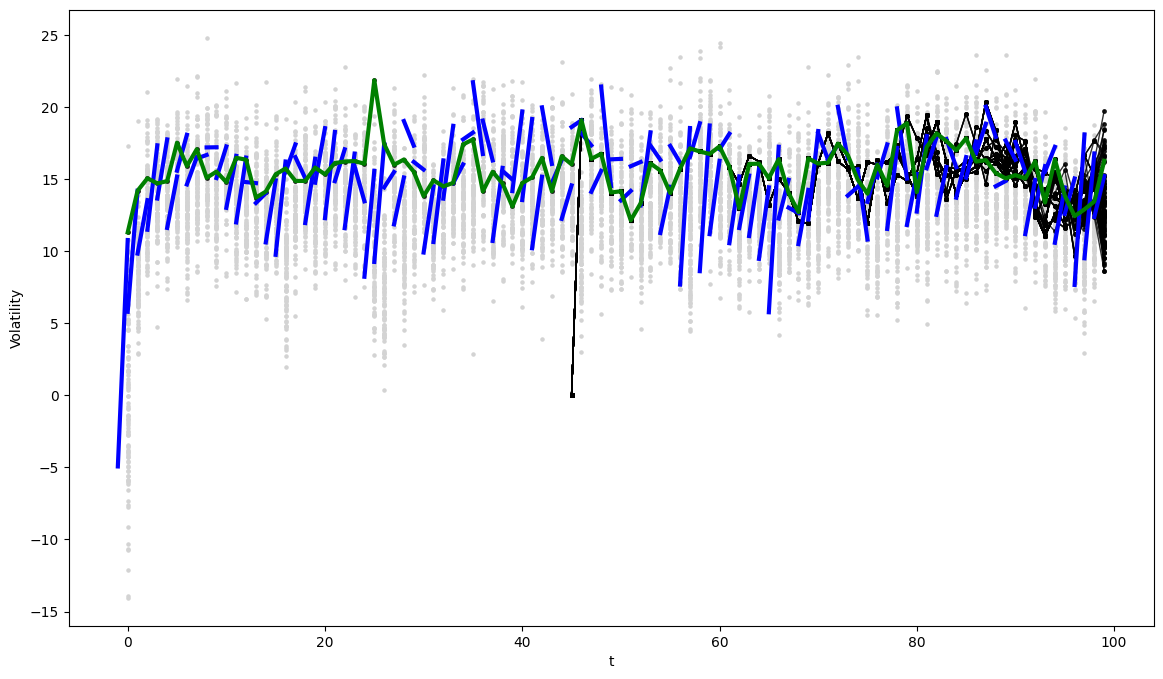

In [227]:
i=0
resampled = lastit[i].xkn[np.arange(0,lastit[i].T),lastit[i].ak[:,lastit[i].K-1]]
particleGeneologyAll("", np.transpose(lastit[i].xkn), np.transpose(lastit[i].ak), x_true=xr[len(xr)-1][i], x_rs=[resampled, xr[len(xr)-2][i]])